In [1]:
%cd "/gscratch/xlab/alisaliu/OLMo"
import olmo

/mmfs1/gscratch/xlab/alisaliu/OLMo


/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
%cd "/gscratch/xlab/alisaliu/superbpe"

import io
import time
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import simdjson as json
import wandb
import zstandard as zstd
from scipy.signal import lfilter, lfiltic
import tempfile
import yaml
import plot_utils
from constants import MODEL_TO_COLOR

api = wandb.Api(timeout=5*60)

/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/mmfs1/gscratch/xlab/alisaliu/pretokenization


In [3]:
STEP_KEY = "_step"
LOSS_KEY = "train/CrossEntropyLoss"
FLOPS_KEY = "throughput/total_training_Gflops"

In [ ]:
RUNS = {
    "OLMo2-7B-pt200k": {
        "wandb_ids": ["AQFCECqu", "TTnazKRN"],
        "bytes_per_token": 4.458679110036542,
        "label": "BPE 8B",
    },
    "OLMo2-7B-pts200k-t80k-ctx2756-colon": {
        "wandb_ids": ["nEdBisVW", "lrYEjoTL"],
        "bytes_per_token": 6.628467570656108,
        "label": "SuperBPE 8B ($t=$80K)",
    },
    "OLMo2-7B-pts200k-t160k-ctx2884-colon": {
        "wandb_ids": ["UniiDEQI"],
        "bytes_per_token": 6.332789818108284,
        "label": "SuperBPE 8B ($t=$160K)",
    },
    "OLMo2-7B-pts200k-t180k-ctx3000-colon": {
        "wandb_ids": ["UUgqEftb", "dtIbsnTR"],
        "bytes_per_token": 6.088411244307862,
        "label": "SuperBPE 8B ($t=$180K)",
    },
    "OLMo2-11B-pts200k-t180k-ctx3000-colon": {
        "wandb_ids": ["mapzLrsG"],
        "bytes_per_token": 6.088411244307862,
        "label": "SuperBPE 11B ($t=$180K)",
    }
}

In [5]:
CONFIG_CACHE = {}

with tempfile.TemporaryFile() as f:
    f.write(b"Hello, world!")
    f.seek(0)
    data = f.read()


def build_model_from_config(config):
    with tempfile.NamedTemporaryFile("w+") as f:
        yaml.dump(config["model"], f)
        model_config = olmo.config.ModelConfig.load(f.name)
    model_config.init_device = "meta"
    model = olmo.model.OLMo(model_config)
    return model


def load_config(name):
    rid = next(iter(RUNS[name]["wandb_ids"]))
    rpath = f"sewoonglab/pretokenization/{rid}"
    if rpath in CONFIG_CACHE:
        return CONFIG_CACHE[rpath]

    config = api.run(rpath).config
    CONFIG_CACHE[name] = config
    return config


def get_train_flops_per_step(name):
    config = load_config(name)
    model = build_model_from_config(config)
    result = config["global_train_batch_size"] * (
        config["model"]["max_sequence_length"]
        * (model.num_fwd_flops + model.num_bck_flops)
    )
    return float(result)


def get_num_params(name, **kwargs):
    config = load_config(name)
    model = build_model_from_config(config)
    return model.num_params(**kwargs)


def get_total_train_tokens(name):
    config = load_config(name)
    return float(
        int(config["max_duration"]) *
        config["model"]["max_sequence_length"] *
        config["global_train_batch_size"]
    )

In [6]:
def ewma_linear_filter(array, window):
    alpha = 2 /(window + 1)
    b = [alpha]
    a = [1, alpha-1]
    zi = lfiltic(b, a, array[0:1], [0])
    return lfilter(b, a, array, zi=zi)[0]

In [7]:
def read_jsonl_zstd(file_path):
    dctx = zstd.ZstdDecompressor()
    with open(file_path, 'rb') as compressed_file:
        with dctx.stream_reader(compressed_file) as decompressed_stream:
            text_stream = io.TextIOWrapper(decompressed_stream, encoding='utf-8')
            parser = json.Parser()
            for line in text_stream:
                if line.strip():
                    yield parser.parse(line).as_dict()


def write_jsonl_zstd(file_path, json_objects):
    cctx = zstd.ZstdCompressor()
    with open(file_path, 'wb') as compressed_file:
        with cctx.stream_writer(compressed_file) as compressed_stream:
            for json_object in json_objects:
                json_line = json.dumps(json_object)
                compressed_stream.write((json_line + '\n').encode('utf-8'))


In [8]:
WANDB_MEM_CACHE = {}

In [9]:
WANDB_CACHE_PATH = Path("data/wandb_cache")
WANDB_MEM_CACHE_EXPIRE_SECS = 60*15  # in seconds

def load_history(name, keys=(LOSS_KEY,)):
    if "/" not in name:
        name = f"sewoonglab/pretokenization/{name}"

    keys = set(keys).union((STEP_KEY,))

    cache_key = name.replace("/", "_")
    cache_file = WANDB_CACHE_PATH / f"{cache_key}.jsonl.zst"
    cache_meta_file = WANDB_CACHE_PATH / f"{cache_key}.meta.json"

    history, cached_meta, mem_keys = [], {}, set()

    # try to load the memory cache
    if cache_key in WANDB_MEM_CACHE:
        cached_meta, mem_keys, history = WANDB_MEM_CACHE[cache_key]
        if not mem_keys.issuperset(keys):
            history = []

    # if the memory cache didn't exist or was invalid, load the disk cache
    if not history:
        try:
            with open(cache_meta_file) as fmeta:
                print(f"run {name}: reading cache from disk")
                cached_meta = json.load(fmeta)
            history = list(read_jsonl_zstd(cache_file))
        except FileNotFoundError:
            history, last_step = [], -1

    # if cache is fresh enough, skip update
    last_step = cached_meta.get("last_step", -1)
    if cached_meta.get("cache_time", 0) + WANDB_MEM_CACHE_EXPIRE_SECS >= time.time():
        return history

    # fetch new rows
    run = api.run(name)
    new_history = list(run.scan_history(min_step=last_step + 1))
    history.extend(new_history)
    new_meta = {"last_step": history[-1][STEP_KEY], "cache_time": time.time()}

    # maybe write out new cache file
    if new_history:
        print(f"run {name}: downloaded {len(new_history)} new rows")

        write_jsonl_zstd(cache_file, history)
        with open(cache_meta_file, "w") as fmeta:
            json.dump(new_meta, fmeta)

    # maybe write to memory cache
    new_mem_keys = mem_keys.union(keys)
    WANDB_MEM_CACHE[cache_key] = (
        new_meta,
        new_mem_keys,
        [{k: entry[k] for k in new_mem_keys if k in entry} for entry in history],
    )

    filtered_history = [{k: entry[k] for k in keys if k in entry} for entry in history]
    return filtered_history

def load_run(run_name, keys=(LOSS_KEY,)):
    histories = {k: {} for k in keys}
    for rid in RUNS[run_name]['wandb_ids']:
        name = f"sewoonglab/pretokenization/{rid}"
        history = load_history(name, keys)
        for entry in history:
            for key in keys:
                if value := entry.get(key):
                    histories[key][entry[STEP_KEY]] = value

    steps = np.array(
        sorted(set.intersection(*(set(h.keys()) for h in histories.values())))
    )
    result = {
        key: np.array([h[step] for step in steps]) for key, h in histories.items()
    }
    result[STEP_KEY] = steps
    return result


def get_bpb(name):
    data = load_run(name, keys=(LOSS_KEY, STEP_KEY))
    loss = data[LOSS_KEY]
    bpb = loss * np.log2(np.e) / RUNS[name]['bytes_per_token']
    return bpb

run sewoonglab/pretokenization/AQFCECqu: reading cache from disk
run sewoonglab/pretokenization/TTnazKRN: reading cache from disk
OLMo2-7B-pt200k: 0.7462913211346834
run sewoonglab/pretokenization/UUgqEftb: reading cache from disk
run sewoonglab/pretokenization/dtIbsnTR: reading cache from disk
OLMo2-7B-pts200k-t180k-ctx3000-colon: 0.7480275268736571
run sewoonglab/pretokenization/mapzLrsG: reading cache from disk
OLMo2-11B-pts200k-t180k-ctx3000-colon: 0.7449217824847633


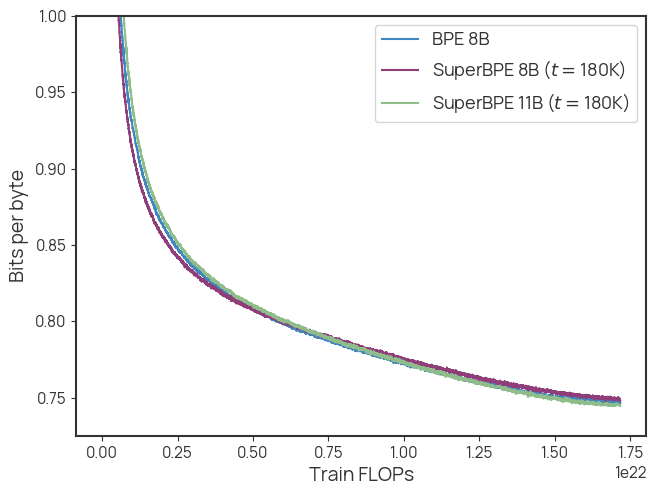

In [10]:
fig, ax = plt.subplots()

all_bpbs = {}
for i, model_name in enumerate([
    "OLMo2-7B-pt200k",
    "OLMo2-7B-pts200k-t180k-ctx3000-colon",
    "OLMo2-11B-pts200k-t180k-ctx3000-colon"
]):
    bpbs = get_bpb(model_name)
    all_bpbs[model_name] = bpbs
    
    smoothed_bpbs = ewma_linear_filter(bpbs, 100)
    print(f"{model_name}: {smoothed_bpbs[-1]}")
    # print(f"{model_name}: {np.mean(bpbs[-100:])}")
    sns.lineplot(
        x=load_run(model_name, keys=(LOSS_KEY, STEP_KEY))[STEP_KEY] * get_train_flops_per_step(model_name),
        y=smoothed_bpbs,
        label=RUNS[model_name]["label"],
        ax=ax,
        color=MODEL_TO_COLOR[model_name],
    )
ax.set_xlabel("Train FLOPs")
ax.set_ylabel("Bits per byte")

plt.legend(fontsize=13)
ax.set_ylim(top=1.0, bottom=0.725)
plt.tight_layout(pad=0.1)
plt.savefig("plots/bpb.png", dpi=300)
plt.savefig("plots/bpb.pdf", dpi=300)